The objective is to finetune an LLM to follow instructions, using an instruction dataset consisting in input-output pairs.
Examples:
- Instruction: Convert 45 kilometers to meters -> Response: 45 kilometers is 45000 meters
- Provide a synonym for bright -> A synonym for "bright" is "radiant"

***1) Loading the dataset***

In [1]:
#Loading the dataset
#Dataset consists of 1100 instruction-response pairs
import json
import os
import urllib
import numpy as np

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://github.com/luiscstr/LLMs/blob/main/Finetuning_to_follow_instructions/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [3]:
print("Example entry:\n", data[999])

Example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


There are various prompt styles. We will use Alpaca style, which consist in a structure with defined sections for instruction, input, an response. Other example of format is Phi-3 which employes a <user> and <assistant> format

Example of Alpaca Style:

***Below is an instruction that describes a task. Write a response that appropiately completes the request***

***###Instruction:***
<br> 
Identify the correct spelling of the following word

***###Input:***
<br> 
Ocassion


***###Response:***
<br> 
The correct spelling is 'Occasion.'

In [4]:
#Creating a format function to format the instructions with Alpaca Style

def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [5]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [6]:
#If there is no input the input sections is skipped
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
The correct spelling is 'Occasion.'


In [7]:
#Splitting in train, test, validation
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)   # 10% for testing
val_portion = len(data) - train_portion - test_portion  # 5% for validation
 
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]
 
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


***2. Batching the dataset***

Need to create a custom collate function to handle the requirements and formatting of the instructions dataset. 
Steps:
- Format data using prompt template
- Tokenize formated data
- Adjust length with padding tokens
- Create target token IDs
- Replace padding tokens with placeholders

In [8]:
#Class to format the data
import torch
from torch.utils.data import Dataset
 
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data: 
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
 
    def __getitem__(self, index):
        return self.encoded_texts[index]
 
    def __len__(self):
        return len(self.data)

In [9]:
#Tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


In [10]:
#Adjusting length with padding tokens
#Defining a custom collate function that pads the training data in each batch to have the same length (length of the longest
#text in the batch) The function allow different batchs to have different lengths.
def custom_collate_draft(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch) #Find the longest sequence in the batch
    inputs_lst, targets_lst = [], []
 
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
 
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
    
        inputs = torch.tensor(padded[:-1]) #Remove extra padded token added earlier
        targets = torch.tensor(padded[1:]) #Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)
        
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor,targets_tensor 


In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]
batch = (
    inputs_1,
    inputs_2,
    inputs_3
)
inputs, targets = custom_collate_draft(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [12]:
#Modify our custom collate function to replace tokens with ID 50256 with -100 in the target lists. This is
#to ignore the end-of-text tokens added as a padding when calculating the cross entropy loss function
#Also introduces an allowed_max_length parameter to optionally limit the length of the samples. 
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    batch_max_length = max(len(item)+1 for item in batch)
    inputs_lst, targets_lst = [], []
 
    for item in batch:
        new_item = item.copy()
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
 
        mask = targets == pad_token_id   #Replace all but the first padding tokens in targets by ignore_index
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
 
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
 
        inputs_lst.append(inputs)
        targets_lst.append(targets)
 
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [13]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


There are two approaches with the target text:
- Masking the instruction tokens (instruction + input) and keep only the response. The idea is to train the model to focus on generating responses rather than memorizing instructions.
- Don't mask the instructions.

Researchers are divided bon whether masking the instructions is universally benficial. We will try and compare both approaches.

***3. Creating the data loaders***

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.backends.mps.is_available():
#     device = torch.device("mps")"
print("Device:", device)

Device: cuda


In [15]:
torch.cuda.is_available()

True

In [16]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [17]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [18]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [19]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [20]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [21]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


***4) Loading pretrained LLM***

In [22]:
from Classes import GPTModel,load_weights_into_gpt,generate,text_to_token_ids,token_ids_to_text, calc_loss_loader, train_model_simple, plot_losses
from gpt_download import download_and_load_gpt2

In [23]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}
 
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
 
CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
 
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
 
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


First, we will assess the pretrained LLM without finetunning to obtain a baseline

In [24]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [25]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)


In [26]:
response_text = generated_text[len(input_text):].strip()#remocing the input text
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


The model is not able to follow the instruction. It seems is just copying the instruction.

***5) Finetunning the LLM on instruction data***

In [27]:
#Calculating the initial loss for the training and validation sets
model.to(device)
torch.manual_seed(123)
 
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
 
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825910139083862
Validation loss: 3.761934280395508


In [28]:
#Training the model
import time
 
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2
 
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)
 
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

NameError: name 'MaxNLocator' is not defined

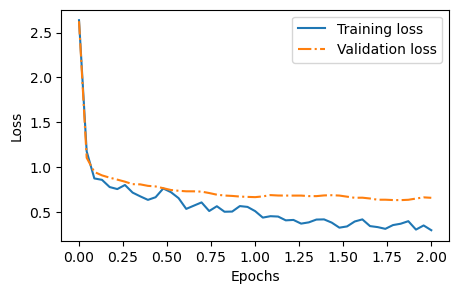

In [30]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

The generated responses are correct. The loss curves also indicate that the model's performance on both training and validation sets improve over the training, specially during the initial pahse of training, 
However, the most crucial aspect is the response quality and correctness, which need to be evaluated.

In [ ]:
#Further work
#Using other kind of prompting
#Use alpaca dataset his dataset contains 52,002 entries, which is approximately 50 times more than those we used in this chapter, and most entries are longer as well. Thus, it's highly recommended to conduct the training using a GPU to accelerate the finetuning process. If you encounter out-of-memory errors, consider reducing the batch_size from 8 to 4, 2, or even 1. Additionally, lowering the allowed_max_length from 1024 to 512 or 256 can further help manage memory issues.
#Evaluate model using Open AI rather than Llama 3

***6) Evaluating the LLM***

In [31]:
#Gnerating responses for the three first instructions and comparing agains the true responses
torch.manual_seed(123)
 
for entry in test_data[:3]: 
    input_text = format_input(entry)
    token_ids = generate( 
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
 
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Pre

The models seems to perform relatively we. The first and third are correct. The second one is partially correct because answers cumulus cloud vs cumulomimbus, which is not exactly the same.

Inspect all instructions this way would be too time consuming. We will use an approach inspired vy AlpacaEval (https://tatsu-lab.github.io/alpaca_eval/) to leverage another LLM to evaluate our model's responses.

In [32]:
#Generating the responses of the test set and add them to the test_set file
from tqdm import tqdm
 
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    input_text = format_input(entry)
 
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    test_data[i]["model_response"] = response_text
 
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:44<00:00,  1.05it/s]


In [33]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [34]:
#Saving model
import re
 
# Remove white spaces and parentheses from file name
file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")
#The saved model can then be loaded via model.load_state_dict(torch.load("gpt2-medium355M-sft.pth")).

Model saved as gpt2-medium355M-sft.pth


We will use LLama 3 8B via Ollama to evaluate our LLM (ollama run llama3)

In [35]:
#After initiating Ollama3 we verify that is running
import psutil
 
def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running
 
ollama_running = check_if_running("ollama")
 
if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [36]:
To load the model
'''
import json
from tqdm import tqdm
 
file_path = "instruction-data-with-response.json"
with open(file_path, "r") as file:
    test_data = json.load(file)
 
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
 
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
       return instruction_text + input_text
'''

'\nTo load the model\nimport json\nfrom tqdm import tqdm\n \nfile_path = "instruction-data-with-response.json"\nwith open(file_path, "r") as file:\n    test_data = json.load(file)\n \ndef format_input(entry):\n    instruction_text = (\n        f"Below is an instruction that describes a task. "\n        f"Write a response that appropriately completes the request."\n        f"\n\n### Instruction:\n{entry[\'instruction\']}"\n    )\n \n    input_text = f"\n\n### Input:\n{entry[\'input\']}" if entry["input"] else ""\n       return instruction_text + input_text\n'

In [37]:
#Alternative way to inrecat with Ollama via REST API
'''
import urllib.request
 
def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    data = {
        "model": model,
        "seed": 123,        # for deterministic responses
        "temperature": 0,   # for deterministic responses
        "messages": [
            {"role": "user", "content": prompt}
        ]
    }
 
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")
 
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
 
    return response_data
    '''